# Estimize Post-Earnings Strategy

In [2]:
# Imports

from datetime import timedelta
from IPython.display import display, HTML, Markdown
import logging.config
import os
import sys

from injector import Injector
import math
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mstats

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetService, CalendarService, EstimizeSignalService, EstimizeConsensusService, MarketCapService
)
from estimize.pandas import dfutils


In [3]:
TIMEZONE = 'US/Eastern'

# Asset universe parameters:
MIN_MARKET_CAP = 100e6
MIN_AVG_DOLLAR_VOL = 1e6
MIN_PRICE = 4

# Signal parameters:
POST_SIGNAL_ONLY = False # If True, only post-earnings signal is used

# Trading parameters:
SIGNAL_QUANTILE = 0.20 # Upper and lower signal quantile to select assets
MIN_ASSETS = 20 # Min number of total long and short assets, below which no trades occur
LEVERAGE_RATIO = 2

configure_logging('INFO')

injector = Injector([DefaultModule])
asset_service = injector.get(AssetService)
calendar_service = injector.get(CalendarService)
consensus_service = injector.get(EstimizeConsensusService)

def shift_date_fn(days):
    if days > 0:
        index = -1
    else:
        index = 0
    
    def shift_date(date):
        if days != 0:
            return calendar_service.get_n_trading_days_from(days, date)[index]
        else:
            return date
    
    return shift_date   
        
def fix_row_index(row):
    index = row[0]
    cols = row[1]
    date = index[0]
    asset = index[1]

    if cols['bmo']:
        date = date - timedelta(days=1)

    date = calendar_service.get_valid_trading_end_date(date)

    return date, asset

def fix_index(df):
    df.index = pd.MultiIndex.from_tuples(list(map(fix_row_index, df.iterrows())))
    df.index.names = ['as_of_date', 'asset']

def get_assets(tickers):
    asset_service = injector.get(AssetService)
    
    return asset_service.get_assets(tickers)

def get_unique_assets(df):
    return dfutils.unique_assets(df)

def universe(start_date, end_date):
    asset_service = injector.get(AssetService)
    market_cap_service = injector.get(MarketCapService)
    
    cdf = market_cap_service.get_market_caps(start_date, end_date)
    print(len(cdf))
    cdf = cdf.loc[cdf['market_cap'] >= MIN_MARKET_CAP]
    print(len(cdf))
    
    df = asset_service.get_universe(start_date, end_date, min_avg_dollar_vol=MIN_AVG_DOLLAR_VOL, min_price=MIN_PRICE)
    df = df.join(cdf, how='inner')
    df = df[[]]
    
    return df

def returns(start_date, end_date, assets, return_columns=['open_return', 'close_return', 'inter_day_return', 'intra_day_return']):
    df = asset_service.get_returns(start_date, end_date, assets)[return_columns]
    
    return df

def eps_deltas(start_date, end_date):
    df = consensus_service.get_final_consensuses(start_date, end_date)
    fix_index(df)
    
    df['eps_delta'] = (df['actual.eps'] - df['estimize.eps.weighted']) / (df['estimize.eps.sd'] + 0.01)
    df = df[['eps_delta']].copy()
    df.dropna(inplace=True)
    
    return df

def longs_and_shorts(eps_deltas_df):
    df = eps_deltas_df.reset_index()
    
    def long_short_fn(values):
        top_quantile = values.quantile(1 - SIGNAL_QUANTILE)
        bottom_quantile = values.quantile(SIGNAL_QUANTILE)

        return ((values >= top_quantile) * 1 + (values <= bottom_quantile) * -1)
    
    df['long_short'] = df.groupby('as_of_date')['eps_delta'].transform(long_short_fn).astype('int')
    df = df[df['long_short'] != 0]
    
    df['count'] = df.groupby('as_of_date')['asset'].transform(lambda values: values.count())
    df = df[df['count'] >= MIN_ASSETS]
    
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    return df

def strategy_returns(year):
    start_date = '{}-01-01'.format(year)
    end_date = '{}-01-01'.format(year + 1)
    
    df = eps_deltas(start_date, end_date)
    df.index = df.index.set_levels(df.index.levels[0].map(shift_date_fn(1)), 'as_of_date')
    
    df = longs_and_shorts(df)
    udf = universe(start_date, end_date)
    
    df = df.join(udf, how='inner')
    assets = dfutils.unique_assets(df)

    if len(assets) == 0:
        return pd.DataFrame(columns=['as_of_date', 'return'])
    
    rdf = returns(start_date, end_date, assets, return_columns=['open_return'])
    rdf.rename(columns={'open_return': 'return'}, inplace=True)
    
    df = df.join(rdf, how='inner')
    print(df.dtypes)
    df['return'] *= df['long_short']
    df.reset_index(inplace=True)
    df = df.groupby('as_of_date')[['return']].mean()
    
    return df

def show_cumulative_returns(df):
    if not df.empty:
        cdf = ((df + 1).cumprod() - 1) * 100
        cdf.plot()
        plt.xlabel('')
        plt.ylabel('')
        plt.legend(
            ['Cumulative Return'],
            bbox_to_anchor=(0.50, 0.96),
            loc="upper center",
            borderaxespad=0,
            ncol=1
        )
        plt.show()
    
def performance_summary(df):
    if df.empty:
        return None
    
    df.dropna(inplace=True)
    numday = df['return'].count()
    avgret = df['return'].mean()
    stdret = np.std(df['return'])
    
    data = []
    
    if numday > 0 and stdret > 0:
        cumret = ((df['return'] + 1).prod() - 1)
        annret = avgret * 252
        volatl = stdret * math.sqrt(252)
        sharpe = math.sqrt(252) * (avgret / stdret)
        
        data = np.array([df.index[0].year, cumret, avgret, numday, annret, sharpe, volatl]).reshape(1, 7)
        
    columns = [
        'Year',
        'Cumulative Return',
        'Avg Daily Return',
        'Num Trading Days',
        'Return (Annualized)',
        'Sharpe Ratio',
        'Volatility'
    ]
    
    pdf = pd.DataFrame(data=data, columns=columns)
    pdf['Year'] = pdf['Year'].astype(int)
    
    return pdf

def show_yearly_performance(years):
    rdfs = []
    perfs = []
    
    for year in years:
        srdf = strategy_returns(year)
        srdf['return'] *= LEVERAGE_RATIO

        perf = performance_summary(srdf)
        display(perf)
        
        show_cumulative_returns(srdf)
        
        if srdf is not None:
            rdfs.append(srdf)
            
        if perf is not None:
            perfs.append(perf)
    
    ardf = pd.concat(rdfs)
    aperf = pd.concat(perfs)
    
    show_cumulative_returns(ardf)
    
    aperf.drop(['Year'], axis=1, inplace=True)
    aperf = aperf.mean().to_frame().transpose()
    display(aperf)

    return ardf

def show_yearly_performance_as_table(ardf):
    cdf = ((ardf + 1).cumprod() - 1) * 100

    print(len(cdf))

    group_size = 60
    num_groups = int(math.ceil(float(len(cdf)) / group_size))

    for i in range(0, num_groups):
        start = i * group_size
        end = start + 60

        if end > len(cdf):
            end = -1

        pdf = cdf.iloc[start:end]
        display(pdf)
        
def display_positions(year):
    sdf = signals(year)
    df = longs_and_shorts(sdf)
    
    df.reset_index(inplace=True)
    df['ticker'] = list(map(lambda a: a.symbol, df['asset']))
    df['trade_time'] = 'Market Open'
    df.loc[df['hour'] == 14, 'trade_time'] = 'Market Close'
    df = df[['as_of_date', 'trade_time', 'ticker', 'long', 'short']]
    
    display(df)
    
    return df


2018-08-14 16:33:01,851 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: start
2018-08-14 16:33:02,040 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: end
585083
573805


None

2018-08-14 16:33:11,517 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: start
2018-08-14 16:33:11,584 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: end
685505
679256
eps_delta     float64
long_short      int64
count          object
return        float64
dtype: object


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2013,0.023941,0.008084,3.0,2.037213,7.021492,0.29014


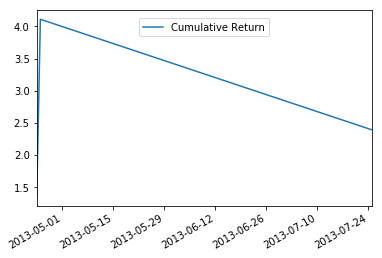

2018-08-14 16:33:21,307 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: start
2018-08-14 16:33:21,372 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: end
737635
734594
eps_delta     float64
long_short      int64
count          object
return        float64
dtype: object


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2014,0.193383,0.009604,19.0,2.420277,6.739101,0.359139


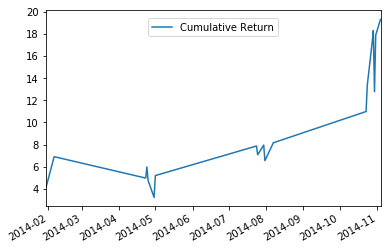

2018-08-14 16:33:31,612 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: start
2018-08-14 16:33:31,679 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: end
751815
745299
eps_delta     float64
long_short      int64
count          object
return        float64
dtype: object


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2015,0.450617,0.009665,40.0,2.43562,5.978308,0.40741


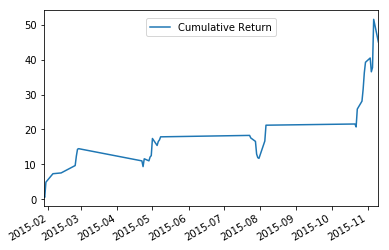

2018-08-14 16:33:42,463 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: start
2018-08-14 16:33:42,662 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: end
757698
745295
eps_delta     float64
long_short      int64
count          object
return        float64
dtype: object


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2016,0.520543,0.009401,46.0,2.369007,6.660622,0.355674


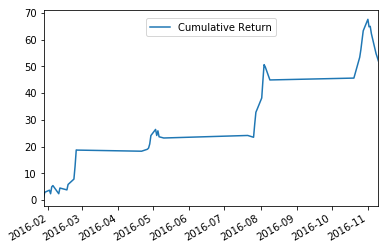

2018-08-14 16:33:53,702 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: start
2018-08-14 16:33:53,761 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: end
758093
742609
eps_delta     float64
long_short      int64
count          object
return        float64
dtype: object


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2017,0.799383,0.012474,48.0,3.143326,11.01282,0.285424


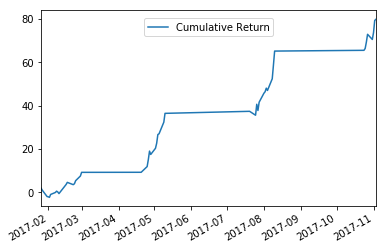

2018-08-14 16:34:05,613 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: start
2018-08-14 16:34:05,672 [INFO] estimize.services.impl.estimize_consensus_service_default_impl: get_final_consensuses: end
184525
180560
eps_delta     float64
long_short      int64
count          object
return        float64
dtype: object


,Year,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,2018,0.050866,0.003536,15.0,0.891035,2.653274,0.335825


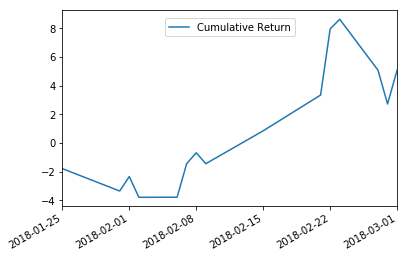

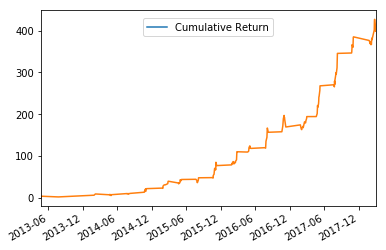

,Cumulative Return,Avg Daily Return,Num Trading Days,Return (Annualized),Sharpe Ratio,Volatility
0,0.339789,0.008794,28.5,2.21608,6.677603,0.338935


In [4]:
df = show_yearly_performance(range(2012, 2019))


In [5]:
# df = display_positions(2017)
# df.to_csv('2017_signal_positions.csv')

# assets = get_assets(['CUDA'])
# df = day_and_night_returns('2016-12-29', '2017-01-9', assets, include_return=True)
# display(df.head())

# df = signals(2017)
# df = df[df.index.get_level_values('asset') == get_assets(['CUDA'])[0]]
# print(len(df))
# display(df.head(10))
# tickers = [a.symbol for a in get_unique_assets(df)]
# tickers.sort()
# display(tickers)

# df = signal_returns(2017)
# display(df.head())